In [ ]:
import zipfile
import os

# Specify the path to your zip file and the extraction directory
zip_file_path = "archive.zip"  # Replace with the actual path to your zip file
extraction_dir = "archive"   # Replace with the desired extraction directory

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_dir, exist_ok=True)

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    print(f"Successfully extracted {zip_file_path} to {extraction_dir}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Successfully extracted archive.zip to archive


Available labels: ['haarcascade_righteye_2splits.xml', 'Closed', 'haarcascade_lefteye_2splits.xml', 'Open', 'no_yawn', 'haarcascade_frontalface_default.xml', 'yawn', 'haarcascade.xml']


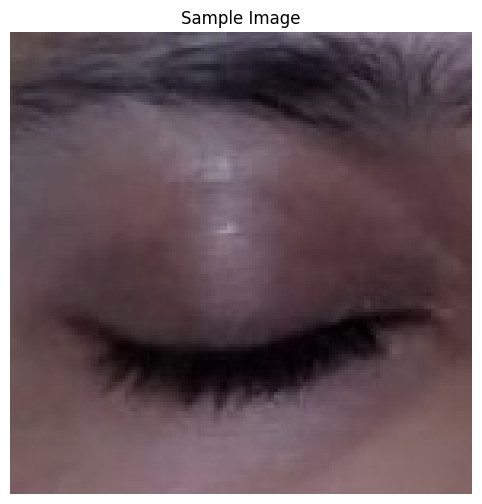

Image shape: (480, 640, 3)


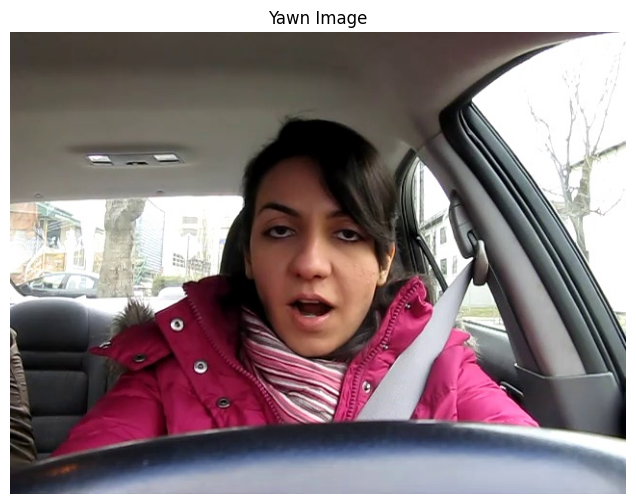

Loading and processing data...
Using default OpenCV cascade
Processing yawn (class 0)


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

"""## Labels"""

labels = os.listdir(r"archive/train")
print("Available labels:", labels)

"""## Visualize A random image"""

# Use forward slashes for better cross-platform compatibility
sample_image_path = r"archive/train/Closed/_0.jpg"
if os.path.exists(sample_image_path):
    plt.figure(figsize=(8, 6))
    plt.imshow(plt.imread(sample_image_path))
    plt.title("Sample Image")
    plt.axis('off')
    plt.show()

"""## Image array and shape"""

sample_yawn_path = r"archive/train/yawn/10.jpg"
if os.path.exists(sample_yawn_path):
    a = plt.imread(sample_yawn_path)
    print("Image shape:", a.shape)

    plt.figure(figsize=(8, 6))
    plt.imshow(a)
    plt.title("Yawn Image")
    plt.axis('off')
    plt.show()

"""## Take only face (For yawn and not_yawn)"""

def face_for_yawn(direc=r"archive/train", face_cas_path=r"archive/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]

    # Check if cascade file exists
    if not os.path.exists(face_cas_path):
        print(f"Warning: Cascade file not found at {face_cas_path}")
        print("Using default OpenCV cascade")
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    else:
        face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        if not os.path.exists(path_link):
            print(f"Warning: Directory {path_link} not found")
            continue

        class_num1 = categories.index(category)
        print(f"Processing {category} (class {class_num1})")

        for image in os.listdir(path_link):
            try:
                image_path = os.path.join(path_link, image)
                image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)

                if image_array is None:
                    continue

                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)

                for (x, y, w, h) in faces:
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yaw_no.append([resized_array, class_num1])
                    break  # Take only the first face detected

            except Exception as e:
                print(f"Error processing {image}: {e}")
                continue

    return yaw_no

"""## For Closed and Open eye"""

def get_data(dir_path=r"archive/train", face_cas=r"archive/haarcascade_frontalface_default.xml",
             eye_cas=r"archive/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    for label in labels:
        path = os.path.join(dir_path, label)
        if not os.path.exists(path):
            print(f"Warning: Directory {path} not found")
            continue

        class_num = labels.index(label)
        class_num += 2  # Offset by 2 to distinguish from yawn classes
        print(f"Processing {label} (class {class_num})")

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)

                if img_array is None:
                    continue

                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])

            except Exception as e:
                print(f"Error processing {img}: {e}")
                continue

    return data

"""## Combine data and convert to array"""

def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no, dtype=object)

# Load and combine all data
print("Loading and processing data...")
new_data = append_data()
print(f"Total samples loaded: {len(new_data)}")

"""## Separate features and labels"""

X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

"""## Reshape the array and normalize"""

X = np.array(X)
X = X.reshape(-1, 145, 145, 3)
# Normalize pixel values to [0, 1]
X = X.astype('float32') / 255.0

print(f"Feature shape: {X.shape}")

"""## Convert labels to categorical"""

# Convert labels to categorical format (one-hot encoding)
num_classes = 4  # yawn, no_yawn, Closed, Open
y = to_categorical(y, num_classes=num_classes)

print(f"Label shape: {y.shape}")
print(f"Number of classes: {num_classes}")

"""## Train Test split"""

seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

"""## Data Augmentation"""

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# Note: Data is already normalized, so no rescaling needed
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

"""## Model Architecture"""

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(145, 145, 3)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Modern optimizer with learning rate scheduling
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

"""## Training with callbacks"""

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)

"""## Plot training history"""

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

"""## Save Model"""

model.save("drowsiness_modern.h5")
model.save("drowsiness_modern.keras")  # Modern Keras format
print("Model saved successfully!")

"""## Evaluation and Predictions"""

# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

"""## Classification Report"""

labels_new = ["yawn", "no_yawn", "Closed", "Open"]
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels_new))

"""## Prediction Function"""

def prepare_image(filepath, face_cas_path=None):
    """
    Prepare image for prediction
    """
    IMG_SIZE = 145

    try:
        img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
        if img_array is None:
            raise ValueError(f"Could not load image from {filepath}")

        # If face cascade is provided, detect face first
        if face_cas_path and os.path.exists(face_cas_path):
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(img_array, 1.3, 5)

            if len(faces) > 0:
                x, y, w, h = faces[0]  # Take the first face
                img_array = img_array[y:y+h, x:x+w]

        # Resize and normalize
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        normalized_array = resized_array.astype('float32') / 255.0

        return normalized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    except Exception as e:
        print(f"Error preparing image {filepath}: {e}")
        return None

def predict_drowsiness(model, image_path, face_cas_path=None):
    """
    Predict drowsiness state from image
    """
    labels_map = {0: "yawn", 1: "no_yawn", 2: "Closed", 3: "Open"}

    prepared_img = prepare_image(image_path, face_cas_path)
    if prepared_img is None:
        return None, None

    prediction = model.predict(prepared_img, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    return labels_map[predicted_class], confidence

"""## Example Predictions"""

# Load the saved model for predictions
try:
    loaded_model = tf.keras.models.load_model("drowsiness_modern.h5")

    # Example predictions (update paths as needed)
    test_images = [
        "archive/train/no_yawn/1067.jpg",
        "archive/train/Closed/_101.jpg",
        "archive/train/yawn/12.jpg"
    ]

    for img_path in test_images:
        if os.path.exists(img_path):
            predicted_label, confidence = predict_drowsiness(loaded_model, img_path)
            if predicted_label:
                print(f"Image: {img_path}")
                print(f"Prediction: {predicted_label} (Confidence: {confidence:.2f})")
                print("-" * 50)
        else:
            print(f"Image not found: {img_path}")

except Exception as e:
    print(f"Error loading model or making predictions: {e}")

In [ ]:
import tensorflow as tf

In [ ]:
# List all physical devices
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU is available:")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU found. Running on CPU.")


GPU is available:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Available labels: ['haarcascade_righteye_2splits.xml', 'Closed', 'haarcascade_lefteye_2splits.xml', 'Open', 'no_yawn', 'haarcascade_frontalface_default.xml', 'yawn', 'haarcascade.xml']


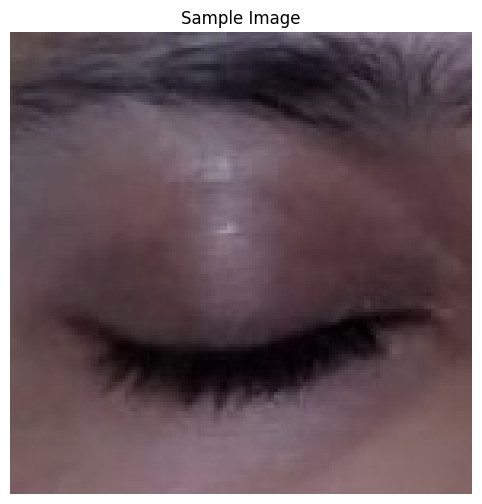

Image shape: (480, 640, 3)


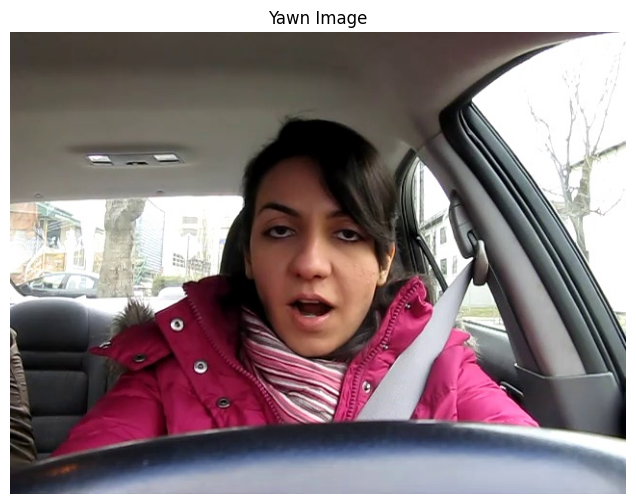

Loading and processing data...
Using default OpenCV cascade
Processing yawn (class 0)
Processing no_yawn (class 1)
Processing Closed (class 2)
Processing Open (class 3)
Total samples loaded: 1919
Feature shape: (1919, 145, 145, 3)
Label shape: (1919, 4)
Number of classes: 4
Label distribution: Counter({np.int64(2): 726, np.int64(3): 726, np.int64(0): 242, np.int64(1): 225})
Training samples: 1343
Testing samples: 576


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 143, 143, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 143, 143, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 71, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 69, 69, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307,460 (8.80 MB)

 Trainable params: 2,306,308 (8.80 MB)

 Non-trainable params: 1,152 (4.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3477 - loss: 1.8626

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 486ms/step - accuracy: 0.3482 - loss: 1.8636 - val_accuracy: 0.3785 - val_loss: 1.5290 - learning_rate: 5.0000e-04
Epoch 2/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.2812 - loss: 3.0567

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2812 - loss: 3.0567 - val_accuracy: 0.3785 - val_loss: 1.5379 - learning_rate: 5.0000e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - accuracy: 0.3355 - loss: 2.4853 - val_accuracy: 0.1684 - val_loss: 1.6261 - learning_rate: 5.0000e-04
Epoch 4/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.5000 - loss: 1.7391

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5000 - loss: 1.7391 - val_accuracy: 0.3351 - val_loss: 1.4077 - learning_rate: 5.0000e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 0.3353 - loss: 1.9350 - val_accuracy: 0.1372 - val_loss: 4.1599 - learning_rate: 5.0000e-04
Epoch 6/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3125 - loss: 2.0606

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3125 - loss: 2.0606 - val_accuracy: 0.1389 - val_loss: 3.9463 - learning_rate: 5.0000e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.3755 - loss: 2.1037 - val_accuracy: 0.2483 - val_loss: 2.0209 - learning_rate: 5.0000e-04
Epoch 8/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5625 - loss: 1.2649

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5625 - loss: 1.2649 - val_accuracy: 0.3819 - val_loss: 1.8213 - learning_rate: 5.0000e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.3436 - loss: 1.9675 - val_accuracy: 0.2222 - val_loss: 1.7994 - learning_rate: 5.0000e-04
Epoch 10/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.2812 - loss: 1.3266

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2812 - loss: 1.3266 - val_accuracy: 0.2309 - val_loss: 1.8203 - learning_rate: 1.0000e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.3604 - loss: 1.8549 - val_accuracy: 0.1406 - val_loss: 2.3944 - learning_rate: 1.0000e-04
Epoch 12/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4062 - loss: 1.2573

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4062 - loss: 1.2573 - val_accuracy: 0.1406 - val_loss: 2.4184 - learning_rate: 1.0000e-04
Epoch 13/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.3618 - loss: 1.5690 - val_accuracy: 0.1719 - val_loss: 3.1670 - learning_rate: 1.0000e-04
Epoch 14/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5312 - loss: 1.2854

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5312 - loss: 1.2854 - val_accuracy: 0.1684 - val_loss: 3.2330 - learning_rate: 1.0000e-04


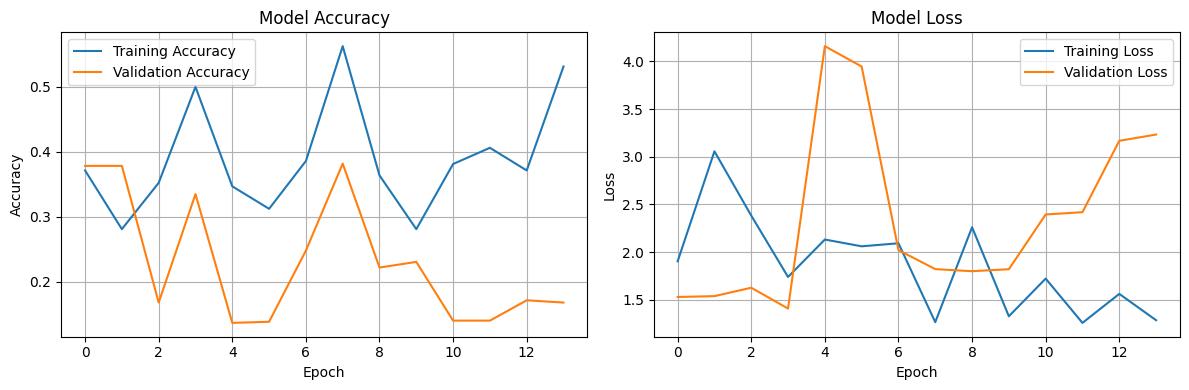

Model saved successfully!
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

Classification Report:
              precision    recall  f1-score   support

        yawn       0.00      0.00      0.00        73
     no_yawn       0.22      0.97      0.36        67
      Closed       0.00      0.00      0.00       218
        Open       0.46      0.59      0.51       218

    accuracy                           0.34       576
   macro avg       0.17      0.39      0.22       576
weighted avg       0.20      0.34      0.24       576



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


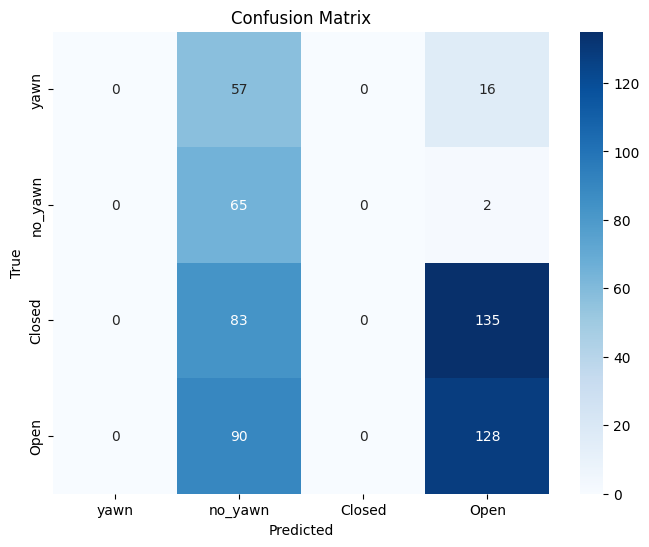

Image: archive/train/no_yawn/1067.jpg
Prediction: no_yawn (Confidence: 0.39)
--------------------------------------------------
Image: archive/train/Closed/_101.jpg
Prediction: no_yawn (Confidence: 0.36)
--------------------------------------------------
Image: archive/train/yawn/12.jpg
Prediction: no_yawn (Confidence: 0.39)
--------------------------------------------------


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

"""## Labels"""

# Check if directory exists before listing
if os.path.exists("archive/train"):
    labels = os.listdir("archive/train")
    print("Available labels:", labels)
else:
    print("Warning: archive/train directory not found")

"""## Visualize A random image"""

# Use forward slashes for better cross-platform compatibility
sample_image_path = "archive/train/Closed/_0.jpg"
if os.path.exists(sample_image_path):
    plt.figure(figsize=(8, 6))
    plt.imshow(plt.imread(sample_image_path))
    plt.title("Sample Image")
    plt.axis('off')
    plt.show()
else:
    print(f"Sample image not found: {sample_image_path}")

"""## Image array and shape"""

sample_yawn_path = "archive/train/yawn/10.jpg"
if os.path.exists(sample_yawn_path):
    a = plt.imread(sample_yawn_path)
    print("Image shape:", a.shape)

    plt.figure(figsize=(8, 6))
    plt.imshow(a)
    plt.title("Yawn Image")
    plt.axis('off')
    plt.show()
else:
    print(f"Sample yawn image not found: {sample_yawn_path}")

"""## Take only face (For yawn and not_yawn)"""

def face_for_yawn(direc="archive/train", face_cas_path="archive/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]

    # Check if cascade file exists
    if not os.path.exists(face_cas_path):
        print(f"Warning: Cascade file not found at {face_cas_path}")
        print("Using default OpenCV cascade")
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    else:
        face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        if not os.path.exists(path_link):
            print(f"Warning: Directory {path_link} not found")
            continue

        class_num1 = categories.index(category)
        print(f"Processing {category} (class {class_num1})")

        for image in os.listdir(path_link):
            try:
                image_path = os.path.join(path_link, image)
                image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)

                if image_array is None:
                    continue

                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)

                for (x, y, w, h) in faces:
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yaw_no.append([resized_array, class_num1])
                    break  # Take only the first face detected

            except Exception as e:
                print(f"Error processing {image}: {e}")
                continue

    return yaw_no

"""## For Closed and Open eye"""

def get_data(dir_path="archive/train", face_cas="archive/haarcascade_frontalface_default.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []

    for label in labels:
        path = os.path.join(dir_path, label)
        if not os.path.exists(path):
            print(f"Warning: Directory {path} not found")
            continue

        class_num = labels.index(label)
        class_num += 2  # Offset by 2 to distinguish from yawn classes
        print(f"Processing {label} (class {class_num})")

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)

                if img_array is None:
                    continue

                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])

            except Exception as e:
                print(f"Error processing {img}: {e}")
                continue

    return data

"""## Combine data and convert to array"""

def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no, dtype=object)

# Load and combine all data
print("Loading and processing data...")
new_data = append_data()
print(f"Total samples loaded: {len(new_data)}")

# Check if we have any data
if len(new_data) == 0:
    print("No data loaded. Please check your directory structure and file paths.")
    exit()

"""## Separate features and labels"""

X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

"""## Reshape the array and normalize"""

X = np.array(X)
X = X.reshape(-1, 145, 145, 3)
# Normalize pixel values to [0, 1]
X = X.astype('float32') / 255.0

print(f"Feature shape: {X.shape}")

"""## Convert labels to categorical"""

# Convert labels to categorical format (one-hot encoding)
num_classes = 4  # yawn, no_yawn, Closed, Open
y = to_categorical(y, num_classes=num_classes)

print(f"Label shape: {y.shape}")
print(f"Number of classes: {num_classes}")
y_labels = np.argmax(y, axis=1)
print("Label distribution:", Counter(y_labels))

"""## Train Test split"""

seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

"""## Data Augmentation"""

train_datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0
)

# Validation data generator (no augmentation)
val_datagen = ImageDataGenerator()

# Note: Data is already normalized, so no rescaling needed
train_generator = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

"""## Model Architecture"""

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(145, 145, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Modern optimizer with learning rate scheduling
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

"""## Training with callbacks"""

# Add callbacks for better training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001
    )
]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

"""## Plot training history"""

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

"""## Save Model"""

model.save("drowsiness_modern.h5")
model.save("drowsiness_modern.keras")  # Modern Keras format
print("Model saved successfully!")

"""## Evaluation and Predictions"""

# Make predictions on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

"""## Classification Report"""

labels_new = ["yawn", "no_yawn", "Closed", "Open"]
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=labels_new))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Heatmap for Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_new, yticklabels=labels_new)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

"""## Prediction Function"""

def prepare_image(filepath, face_cas_path=None):
    """
    Prepare image for prediction
    """
    IMG_SIZE = 145

    try:
        img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
        if img_array is None:
            raise ValueError(f"Could not load image from {filepath}")

        # If face cascade is provided, detect face first
        if face_cas_path and os.path.exists(face_cas_path):
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(img_array, 1.3, 5)

            if len(faces) > 0:
                x, y, w, h = faces[0]  # Take the first face
                img_array = img_array[y:y+h, x:x+w]

        # Resize and normalize
        resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
        normalized_array = resized_array.astype('float32') / 255.0

        return normalized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    except Exception as e:
        print(f"Error preparing image {filepath}: {e}")
        return None

def predict_drowsiness(model, image_path, face_cas_path=None):
    """
    Predict drowsiness state from image
    """
    labels_map = {0: "yawn", 1: "no_yawn", 2: "Closed", 3: "Open"}

    prepared_img = prepare_image(image_path, face_cas_path)
    if prepared_img is None:
        return None, None

    prediction = model.predict(prepared_img, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    return labels_map[predicted_class], confidence

"""## Example Predictions"""

# Load the saved model for predictions
try:
    loaded_model = tf.keras.models.load_model("drowsiness_modern.h5")

    # Example predictions (update paths as needed)
    test_images = [
        "archive/train/no_yawn/1067.jpg",
        "archive/train/Closed/_101.jpg",
        "archive/train/yawn/12.jpg"
    ]

    for img_path in test_images:
        if os.path.exists(img_path):
            predicted_label, confidence = predict_drowsiness(loaded_model, img_path)
            if predicted_label:
                print(f"Image: {img_path}")
                print(f"Prediction: {predicted_label} (Confidence: {confidence:.2f})")
                print("-" * 50)
        else:
            print(f"Image not found: {img_path}")

except Exception as e:
    print(f"Error loading model or making predictions: {e}")

Starting driver drowsiness detection training...
Combining datasets...
Loading yawn detection data...
Processing yawn - Class: 0
Processing no_yawn - Class: 1
Loading eye data...
Processing Closed - Class: 2
Processing Open - Class: 3
Dataset shape: (1919, 145, 145, 3), Labels shape: (1919, 4)
Training set: (1343, 145, 145, 3), Test set: (576, 145, 145, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 143, 143, 256)  │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 71, 71, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       100,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,140 (1.89 MB)

 Trainable params: 495,140 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.3679 - loss: 1.3381

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 33s 512ms/step - accuracy: 0.3696 - loss: 1.3366 - val_accuracy: 0.5382 - val_loss: 0.9679
Epoch 2/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.5625 - loss: 1.0546

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5625 - loss: 1.0546 - val_accuracy: 0.6233 - val_loss: 0.9013
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.6568 - loss: 0.8618 - val_accuracy: 0.8351 - val_loss: 0.3936
Epoch 4/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8125 - loss: 0.4130

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8125 - loss: 0.4130 - val_accuracy: 0.8420 - val_loss: 0.3723
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.7616 - loss: 0.5877 - val_accuracy: 0.8594 - val_loss: 0.4039
Epoch 6/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6875 - loss: 0.7978

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6875 - loss: 0.7978 - val_accuracy: 0.8611 - val_loss: 0.4060
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.7975 - loss: 0.4974 - val_accuracy: 0.8872 - val_loss: 0.2852
Epoch 8/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8125 - loss: 0.3338

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8125 - loss: 0.3338 - val_accuracy: 0.8837 - val_loss: 0.2861
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.8274 - loss: 0.4171 - val_accuracy: 0.8802 - val_loss: 0.3010
Epoch 10/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8750 - loss: 0.3456

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8750 - loss: 0.3456 - val_accuracy: 0.8872 - val_loss: 0.2971
Epoch 11/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.8364 - loss: 0.4069 - val_accuracy: 0.8368 - val_loss: 0.3339
Epoch 12/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8125 - loss: 0.6360

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8125 - loss: 0.6360 - val_accuracy: 0.8802 - val_loss: 0.2704
Epoch 13/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.8230 - loss: 0.4474 - val_accuracy: 0.8993 - val_loss: 0.2310
Epoch 14/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7188 - loss: 0.5637

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7188 - loss: 0.5637 - val_accuracy: 0.9028 - val_loss: 0.2289
Epoch 15/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 0.8300 - loss: 0.3753 - val_accuracy: 0.8976 - val_loss: 0.2404
Epoch 16/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.8750 - loss: 0.2391

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8750 - loss: 0.2391 - val_accuracy: 0.8976 - val_loss: 0.2406
Epoch 17/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.8633 - loss: 0.3402 - val_accuracy: 0.9010 - val_loss: 0.2371
Epoch 18/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.7500 - loss: 0.5952

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7500 - loss: 0.5952 - val_accuracy: 0.9010 - val_loss: 0.2360
Epoch 19/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.8709 - loss: 0.3307 - val_accuracy: 0.9201 - val_loss: 0.2345
Epoch 20/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.8065 - loss: 0.4784

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8065 - loss: 0.4784 - val_accuracy: 0.9201 - val_loss: 0.2105
Epoch 21/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.8656 - loss: 0.2965 - val_accuracy: 0.9410 - val_loss: 0.1768
Epoch 22/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9375 - loss: 0.4090

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.4090 - val_accuracy: 0.9427 - val_loss: 0.1764
Epoch 23/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 0.8754 - loss: 0.2878 - val_accuracy: 0.9288 - val_loss: 0.1746
Epoch 24/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8750 - loss: 0.4434

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8750 - loss: 0.4434 - val_accuracy: 0.9167 - val_loss: 0.1806
Epoch 25/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.8966 - loss: 0.2697 - val_accuracy: 0.9149 - val_loss: 0.1795
Epoch 26/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9375 - loss: 0.1567

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.1567 - val_accuracy: 0.9167 - val_loss: 0.1800
Epoch 27/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.8966 - loss: 0.2600 - val_accuracy: 0.9358 - val_loss: 0.1608
Epoch 28/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9375 - loss: 0.1817

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.1817 - val_accuracy: 0.9306 - val_loss: 0.1677
Epoch 29/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 205ms/step - accuracy: 0.9061 - loss: 0.2472 - val_accuracy: 0.9062 - val_loss: 0.1953
Epoch 30/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9688 - loss: 0.1677

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1677 - val_accuracy: 0.9115 - val_loss: 0.1940
Epoch 31/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.8714 - loss: 0.2659 - val_accuracy: 0.9410 - val_loss: 0.1454
Epoch 32/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9688 - loss: 0.0912

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.0912 - val_accuracy: 0.9358 - val_loss: 0.1450
Epoch 33/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - accuracy: 0.9083 - loss: 0.2177 - val_accuracy: 0.9392 - val_loss: 0.1427
Epoch 34/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9375 - loss: 0.2086

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9375 - loss: 0.2086 - val_accuracy: 0.9427 - val_loss: 0.1480
Epoch 35/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.9099 - loss: 0.2389 - val_accuracy: 0.9392 - val_loss: 0.1457
Epoch 36/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.8438 - loss: 0.2724

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8438 - loss: 0.2724 - val_accuracy: 0.9340 - val_loss: 0.1525
Epoch 37/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.8923 - loss: 0.2447 - val_accuracy: 0.9340 - val_loss: 0.1797
Epoch 38/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8710 - loss: 0.3084

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8710 - loss: 0.3084 - val_accuracy: 0.9323 - val_loss: 0.1780
Epoch 39/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - accuracy: 0.9040 - loss: 0.2301 - val_accuracy: 0.9462 - val_loss: 0.1452
Epoch 40/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9375 - loss: 0.1458

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9375 - loss: 0.1458 - val_accuracy: 0.9444 - val_loss: 0.1438
Epoch 41/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.9149 - loss: 0.2167 - val_accuracy: 0.9271 - val_loss: 0.1527
Epoch 42/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9062 - loss: 0.2281

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9062 - loss: 0.2281 - val_accuracy: 0.9323 - val_loss: 0.1487
Epoch 43/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.9165 - loss: 0.2310 - val_accuracy: 0.9358 - val_loss: 0.1491
Epoch 44/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9688 - loss: 0.1095

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1095 - val_accuracy: 0.9340 - val_loss: 0.1532
Epoch 45/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9273 - loss: 0.1960 - val_accuracy: 0.9618 - val_loss: 0.1313
Epoch 46/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9062 - loss: 0.2465

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9062 - loss: 0.2465 - val_accuracy: 0.9601 - val_loss: 0.1286
Epoch 47/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.9251 - loss: 0.1785 - val_accuracy: 0.9444 - val_loss: 0.1341
Epoch 48/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.9688 - loss: 0.1057

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.1057 - val_accuracy: 0.9410 - val_loss: 0.1435
Epoch 49/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.9120 - loss: 0.2280 - val_accuracy: 0.9514 - val_loss: 0.1199
Epoch 50/50
 1/41 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.9688 - loss: 0.0836

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9688 - loss: 0.0836 - val_accuracy: 0.9497 - val_loss: 0.1217


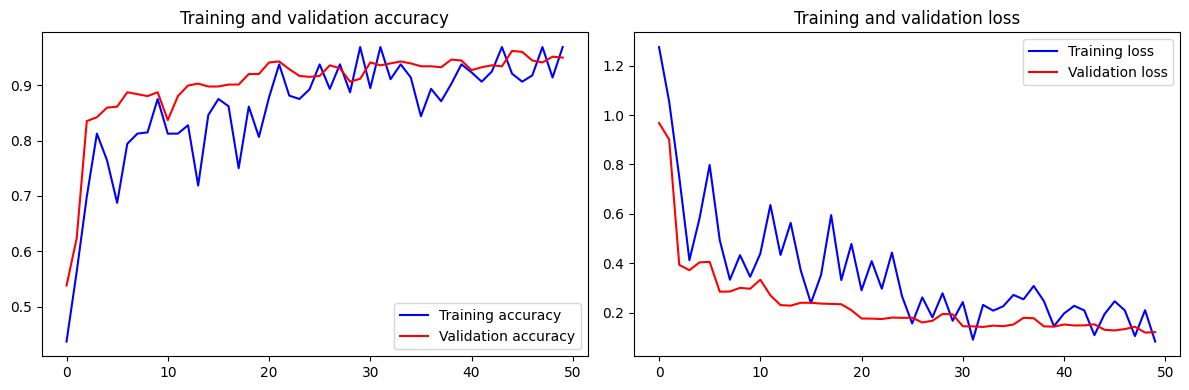

Model saved as 'drowsiness_detection_model.h5'
Test accuracy: 0.9497



Classification Report:
              precision    recall  f1-score   support

        yawn       0.93      0.78      0.85        73
     no_yawn       0.80      0.91      0.85        67
      closed       0.96      0.99      0.98       218
        open       0.99      0.98      0.98       218

    accuracy                           0.95       576
   macro avg       0.92      0.91      0.92       576
weighted avg       0.95      0.95      0.95       576


Making sample predictions...
Image: archive/train/no_yawn/1067.jpg
Predicted class: no_yawn (confidence: 0.7873)
Image: archive/train/Closed/_101.jpg
Predicted class: closed (confidence: 1.0000)
Image: archive/train/yawn/12.jpg
Predicted class: yawn (confidence: 0.6749)


In [ ]:
# -*- coding: utf-8 -*-
"""
Driver Drowsiness Detection System
Updated with modern dependencies and improved code structure
"""

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
IMG_SIZE = 145
BATCH_SIZE = 32
EPOCHS = 50
TEST_SIZE = 0.30
RANDOM_STATE = 42

def get_labels(data_dir):
    """Get available labels from the dataset directory"""
    return os.listdir(data_dir)

def visualize_sample_image(image_path):
    """Visualize a sample image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(plt.imread(image_path))
    plt.title(f"Sample Image: {os.path.basename(image_path)}")
    plt.axis('off')
    plt.show()

def face_detection_yawn(data_dir="archive/train",
                       face_cascade_path="archive/train/haarcascade_frontalface_default.xml"):
    """
    Extract face regions for yawn detection (yawn vs no_yawn)
    """
    yawn_data = []
    categories = ["yawn", "no_yawn"]

    # Load face cascade classifier
    face_cascade = cv2.CascadeClassifier(face_cascade_path)

    for category in categories:
        path_link = os.path.join(data_dir, category)
        class_num = categories.index(category)
        print(f"Processing {category} - Class: {class_num}")

        if not os.path.exists(path_link):
            print(f"Warning: Directory {path_link} not found")
            continue

        for image_file in os.listdir(path_link):
            try:
                image_path = os.path.join(path_link, image_file)
                image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)

                if image_array is None:
                    continue

                # Detect faces
                faces = face_cascade.detectMultiScale(image_array, 1.3, 5)

                for (x, y, w, h) in faces:
                    # Extract face region
                    roi_color = image_array[y:y+h, x:x+w]
                    resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                    yawn_data.append([resized_array, class_num])
                    break  # Take only the first detected face

            except Exception as e:
                print(f"Error processing {image_file}: {e}")
                continue

    return yawn_data

def get_eye_data(data_dir="archive/train"):
    """
    Get eye data (Closed vs Open eyes)
    """
    labels = ['Closed', 'Open']
    eye_data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label) + 2  # Start from 2 to avoid conflict with yawn classes
        print(f"Processing {label} - Class: {class_num}")

        if not os.path.exists(path):
            print(f"Warning: Directory {path} not found")
            continue

        for img_file in os.listdir(path):
            try:
                img_path = os.path.join(path, img_file)
                img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)

                if img_array is None:
                    continue

                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                eye_data.append([resized_array, class_num])

            except Exception as e:
                print(f"Error processing {img_file}: {e}")
                continue

    return eye_data

def combine_datasets():
    """
    Combine yawn and eye datasets
    """
    print("Loading yawn detection data...")
    yawn_data = face_detection_yawn()

    print("Loading eye data...")
    eye_data = get_eye_data()

    # Combine datasets
    yawn_data.extend(eye_data)

    return np.array(yawn_data, dtype=object)

def prepare_data():
    """
    Prepare and preprocess the dataset
    """
    print("Combining datasets...")
    combined_data = combine_datasets()

    # Separate features and labels
    X = []
    y = []

    for feature, label in combined_data:
        X.append(feature)
        y.append(label)

    # Convert to numpy arrays
    X = np.array(X)
    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

    # Normalize pixel values
    X = X.astype('float32') / 255.0

    # Convert labels to categorical
    label_binarizer = LabelBinarizer()
    y = label_binarizer.fit_transform(y)
    y = np.array(y)

    return X, y, label_binarizer

def create_model():
    """
    Create and compile the CNN model
    """
    model = Sequential([
        Conv2D(256, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(4, activation='softmax')  # 4 classes: yawn, no_yawn, closed, open
    ])

    # Compile model with updated optimizer
    model.compile(
        loss='categorical_crossentropy',
        metrics=['accuracy'],
        optimizer=Adam(learning_rate=0.001)
    )

    return model

def create_data_generators(X_train, X_test, y_train, y_test):
    """
    Create data generators for training and validation
    """
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    test_generator = test_datagen.flow(
        X_test, y_test,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    return train_generator, test_generator

def plot_training_history(history):
    """
    Plot training history
    """
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def prepare_single_image(filepath, face_cascade_path="archive/train/haarcascade_frontalface_default.xml"):
    """
    Prepare a single image for prediction
    """
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    if img_array is None:
        raise ValueError(f"Could not load image from {filepath}")

    # Normalize and resize
    img_array = img_array.astype('float32') / 255.0
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

def predict_single_image(model, image_path, class_labels):
    """
    Predict the class of a single image
    """
    try:
        processed_image = prepare_single_image(image_path)
        prediction = model.predict(processed_image, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)

        print(f"Image: {image_path}")
        print(f"Predicted class: {class_labels[predicted_class]} (confidence: {confidence:.4f})")

        return predicted_class, confidence
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, None

def main():
    """
    Main training pipeline
    """
    print("Starting driver drowsiness detection training...")

    # Prepare data
    X, y, label_binarizer = prepare_data()
    print(f"Dataset shape: {X.shape}, Labels shape: {y.shape}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

    # Create model
    model = create_model()
    model.summary()

    # Create data generators (Note: X_train and X_test are already normalized)
    # For generators, we need to pass unnormalized data
    X_train_gen = (X_train * 255).astype('uint8')
    X_test_gen = (X_test * 255).astype('uint8')

    train_generator, test_generator = create_data_generators(
        X_train_gen, X_test_gen, y_train, y_test
    )

    # Train model
    print("Starting training...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=test_generator,
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        validation_steps=len(X_test) // BATCH_SIZE,
        verbose=1
    )

    # Plot training history
    plot_training_history(history)

    # Save model
    model.save("drowsiness_detection_model.h5")
    print("Model saved as 'drowsiness_detection_model.h5'")

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Generate predictions for classification report
    predictions = model.predict(test_generator, verbose=0)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification report
    class_labels = ["yawn", "no_yawn", "closed", "open"]
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    return model, class_labels

# Example usage for prediction
def load_and_predict():
    """
    Load a saved model and make predictions
    """
    try:
        model = tf.keras.models.load_model("drowsiness_detection_model.h5")
        class_labels = ["yawn", "no_yawn", "closed", "open"]

        # Example predictions (update paths as needed)
        test_images = [
            "archive/train/no_yawn/1067.jpg",
            "archive/train/Closed/_101.jpg",
            "archive/train/yawn/12.jpg"
        ]

        for image_path in test_images:
            if os.path.exists(image_path):
                predict_single_image(model, image_path, class_labels)
            else:
                print(f"Image not found: {image_path}")

    except Exception as e:
        print(f"Error loading model: {e}")

if __name__ == "__main__":
    # Run training
    model, class_labels = main()

    # Example predictions
    print("\n" + "="*50)
    print("Making sample predictions...")
    load_and_predict()